This notebook was meant as a personal exercise. I wanted to create something useful to me and practice model training as well. The model performs well enough for the task at hand. I have noticed that the model tends to look for text in the image, and if found, classifies it as a "meme". I feel without contextual knowledge, this is nearly the best results I could eke out of a Computer Vision model. 

# Train

## Imports, Setup, Create Databunch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from tqdm import tqdm_notebook as tqdm
from collections import Counter

In [3]:
from jupyterthemes import jtplot
jtplot.style()

In [4]:
def resize_images(photo_pth, dest_path, size=500):
    '''
        Function to resize all images in photo_pth and paste them in dest_path
    '''
    images = get_image_files(photo_pth)
    for i in tqdm(images):
        try:
            im = open_image(i)
            im.resize(size)
            im.save(dest_path/i.name)
        except:
            continue

In [5]:
# resize_images(path/'temp', train_path/'personal-photos')

In [6]:
path = Path("C:/whatsapp-project-data")

In [7]:
path.ls()

[WindowsPath('C:/whatsapp-project-data/export.pkl'),
 WindowsPath('C:/whatsapp-project-data/Inference'),
 WindowsPath('C:/whatsapp-project-data/Inference22'),
 WindowsPath('C:/whatsapp-project-data/models'),
 WindowsPath('C:/whatsapp-project-data/personal-photos'),
 WindowsPath('C:/whatsapp-project-data/reddit-memes-dataset'),
 WindowsPath('C:/whatsapp-project-data/WhatsApp-Images')]

In [8]:
def get_data(bs=32, size=224):
    np.random.seed(42)
    data = (ImageList.from_folder(path, exclude="WhatsApp-Images")
            .split_by_rand_pct(0.20)
            .label_from_folder()
            .add_test_folder("WhatsApp-Images")
            .transform(get_transforms(), size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats)
           )

    return data

def get_learner(bs=32, size=224):
    learn = cnn_learner(get_data(bs, size), models.resnet34, metrics=accuracy)
    return learn

In [27]:
data = get_data()

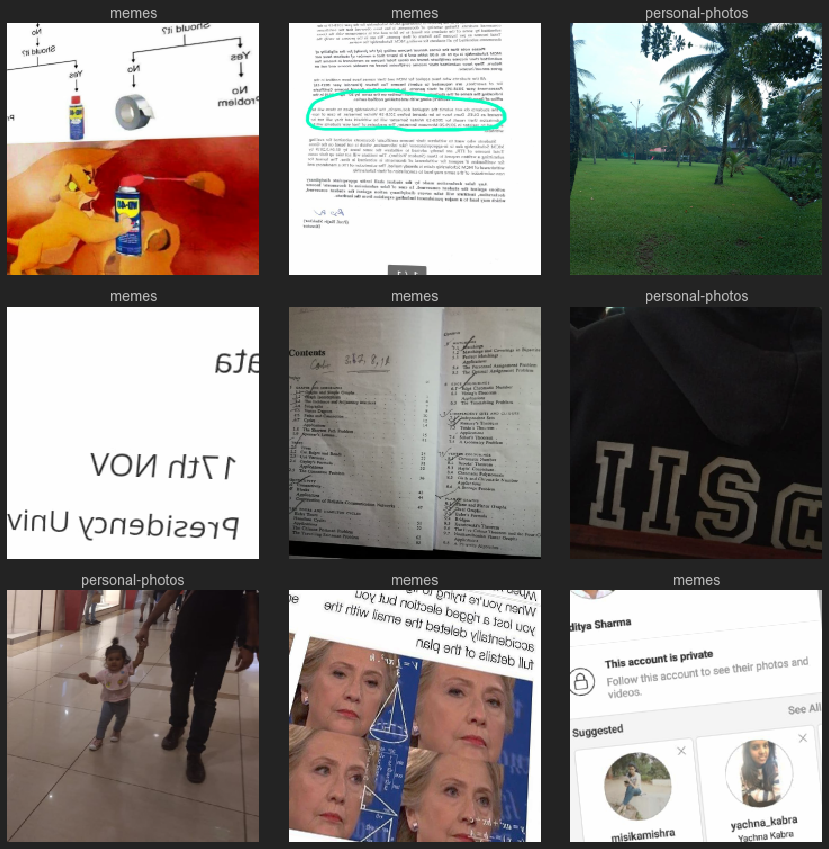

In [30]:
data.show_batch(rows=3)

## Resnet-34 as Baseline

### Frozen Network

In [9]:
data = get_data(bs=64, size=128)

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


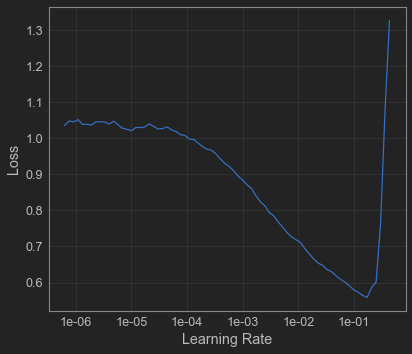

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.338384,0.212842,0.922904,02:12
1,0.226056,0.181772,0.927395,02:11
2,0.182834,0.157908,0.942365,02:09
3,0.153657,0.152853,0.943114,02:10


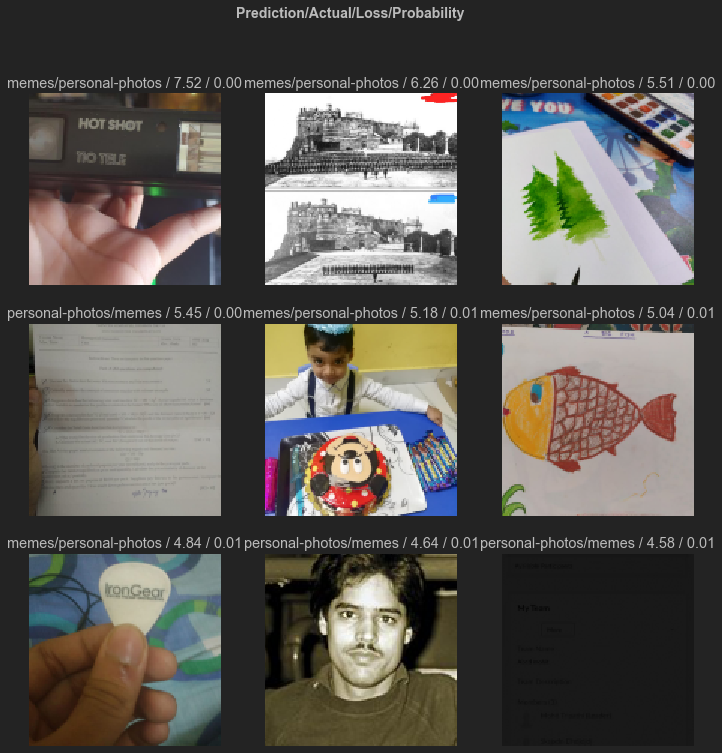

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

In [19]:
learn.save('rsn34-stage1-94.3')

In [11]:
learn.load('rsn34-stage1-94.3');

In [13]:
learn.data = get_data(bs=40, size=224)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


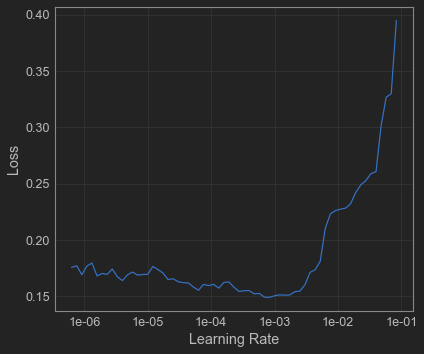

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.125354,0.126662,0.952096,02:38
1,0.095494,0.113948,0.955838,02:40
2,0.077808,0.109011,0.958084,02:39


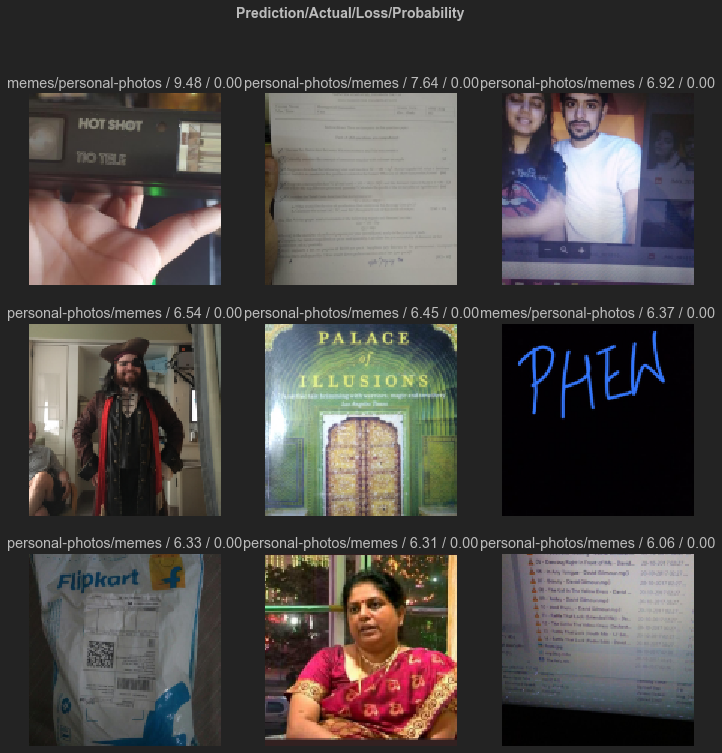

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


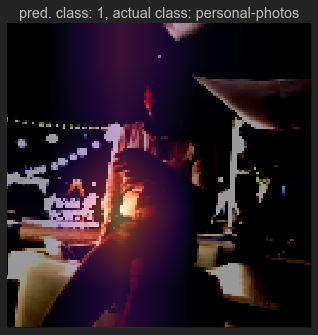

In [16]:
interp.GradCAM(80);

In [ ]:
learn.save('rsn34-stage1-95.8')

In [13]:
learn.load('rsn34-stage1-95.8');

### Unfreeze

In [9]:
learn = get_learner(bs=24, size=500).load('rsn34-stage1-95.8')

In [10]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


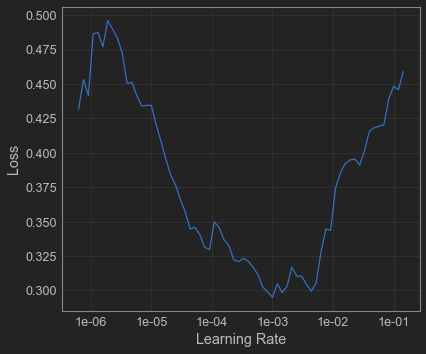

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.329239,0.213754,0.913337,12:26
1,0.225474,0.120569,0.963890,10:22
2,0.172780,0.112157,0.966779,10:45
3,0.160619,0.094379,0.973038,10:47
4,0.152602,0.089919,0.973520,10:49


In [13]:
learn.save('rsn34-stage2-97.35')

In [31]:
# learn.load('rsn34-stage2-97.35');

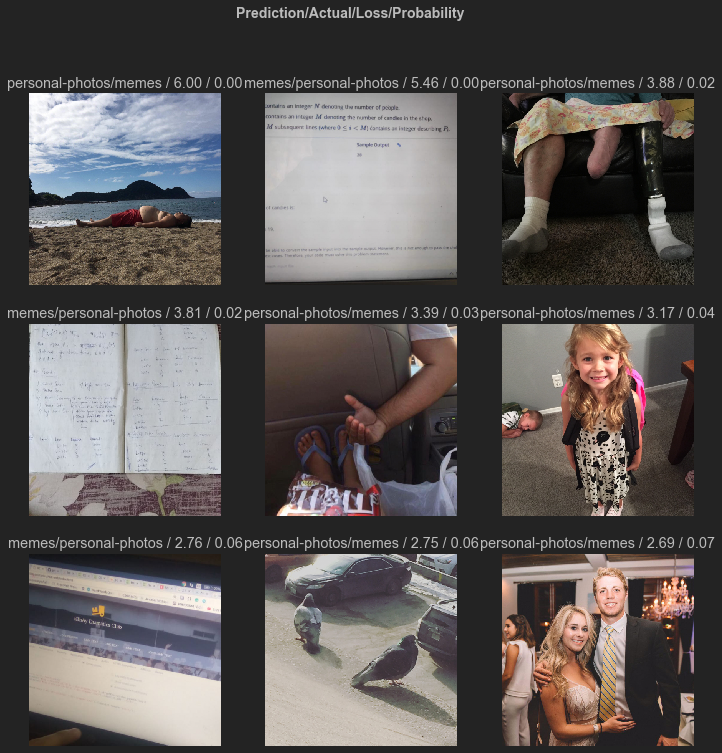

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

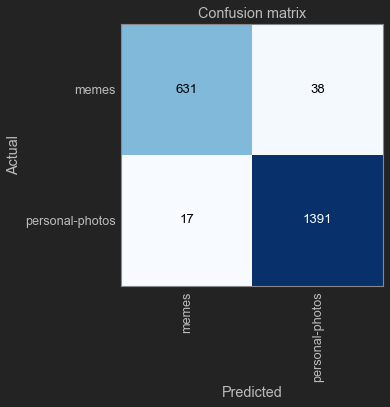

In [15]:
interp.plot_confusion_matrix()

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


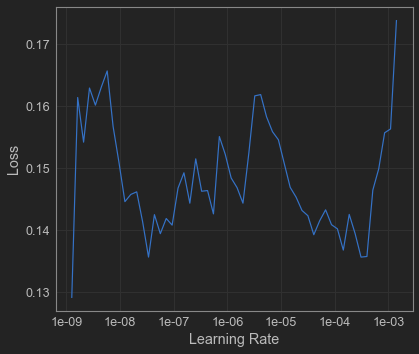

In [21]:
learn.lr_find(start_lr=1e-10)
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, max_lr=slice(1e-7, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.166884,0.087614,0.973038,07:47
1,0.156116,0.080926,0.974964,08:55


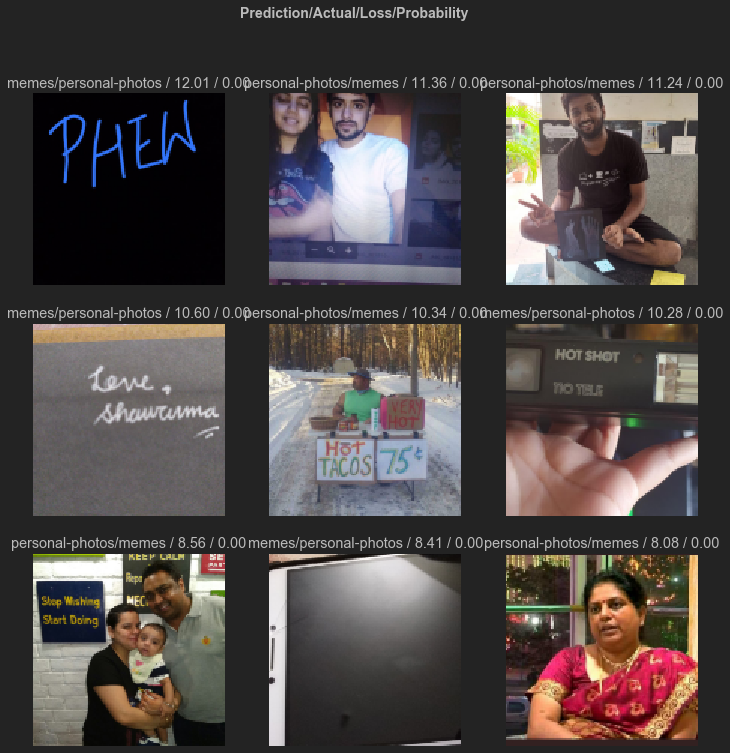

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

In [24]:
learn.save('rsn34-stage2-97.4')

In [17]:
learn.load('rsn34-stage2-97.4');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


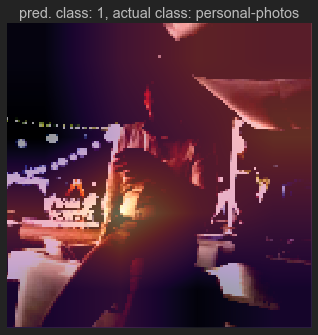

In [19]:
interp.GradCAM(80);

In [ ]:
learn.export()

## Now, I shall save them to folders!

In [37]:
data = get_data(20, 500)
learn = (cnn_learner(data, models.resnet34)).load('rsn34-stage2-97.4')

In [33]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
classes = torch.argmax(preds, dim=1)

In [34]:
test_files = [i.name for i in data.test_ds.x.items]

In [35]:
test_path = path/'WhatsApp-Images'

In [36]:
import os
for cat in data.classes: os.mkdir(path/'Inference'/cat)
for f, c in tqdm(list(zip(test_files, classes))):
    shutil.copy(test_path/f, path/'Inference'/data.classes[c])

# Inference

In [8]:
from fastai.vision import *
from tqdm import tqdm_notebook as tqdm
import os

Please make sure that the Test Folder is flat, i.e. no subdirectories

In [2]:
model_path = Path("C:/whatsapp-project-data") # path that contains export.pkl
test_path = Path("C:/whatsapp-project-data/WhatsApp-Images") # test folder
dest_path = Path("C:/whatsapp-project-data/Inference") # destination folder

In [3]:
learn = load_learner(model_path, test=ImageList.from_folder(test_path))

In [11]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
classes = torch.argmax(preds, dim=1)

In [5]:
test_files = [i.name for i in learn.data.test_ds.x.items]

In [10]:
for cat in learn.data.classes: os.makedirs(dest_path/cat)
for f, c in tqdm(list(zip(test_files, classes))):
    shutil.copy(test_path/f, dest_path/learn.data.classes[c])

# fin